<a href="https://colab.research.google.com/github/WeiKuoLi/Ascii_waves/blob/main/image_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qqq transformers datasets matplotlib

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_mode = "CIFAR10"
# dataset_mode = "MNIST"

Files already downloaded and verified
images shape: torch.Size([20, 3, 224, 224])
images max/min: 1.0, 0.0


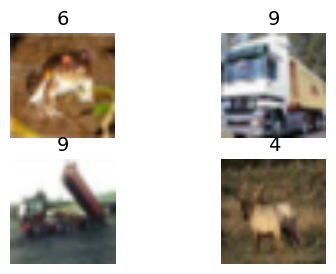

images mean/std: tensor([0.5000, 0.5000, 0.5000]), tensor([0.5000, 0.5000, 0.5000])


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


inputs shape: torch.Size([20, 3, 224, 224])
outputs shape: torch.Size([20, 197, 768])
embeddings shape: (20, 151296)


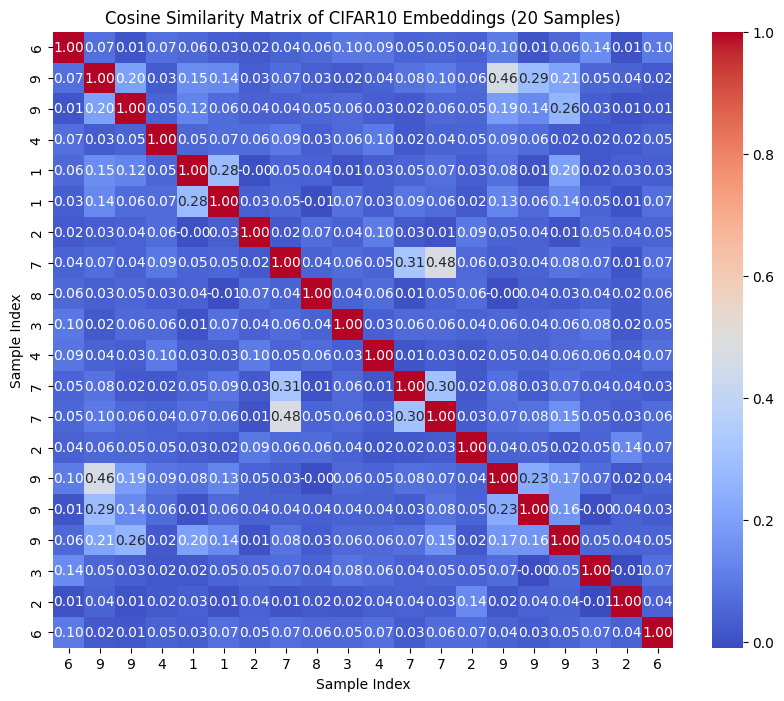

In [4]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, AutoModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load MNIST dataset (using only PyTorch)
transform = T.Compose([
    T.Resize((224, 224)),  # Resize images to match ViT input size
    T.ToTensor(),
])
if dataset_mode == "MNIST":
  from torchvision.datasets import MNIST
  dataset = MNIST(root="./data", train=True, download=True, transform=transform)
elif dataset_mode == "CIFAR10":
  from torchvision.datasets import CIFAR10
  dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)

loader = DataLoader(dataset, batch_size=20, shuffle=False)
images, labels = next(iter(loader))

# transform black and white to colored [20, 1, 224, 224] to [20, 3, 224, 224]
if dataset.__class__.__name__ == "MNIST":
  images = torch.cat([images, images, images], dim=1)
elif dataset.__class__.__name__ == "CIFAR10":
  pass
print(f"images shape: {images.shape}")
print(f"images max/min: {images.max()}, {images.min()}")

# Plot first 4 images
fig, ax = plt.subplots(2,2, figsize=(5, 3))
for i in range(4):
    ax[i//2, i%2].imshow(images[i].permute(1, 2, 0).numpy())
    ax[i//2, i%2].axis('off')
    ax[i//2, i%2].set_title(labels[i].item(), fontsize=14)
plt.show()

# normalize images to mean and std of 0.5 for all channels
images = (images - images.mean(dim=(2, 3), keepdim=True)) / images.std(dim=(2, 3), keepdim=True)
images = images * 0.5 + 0.5
print(f"images mean/std: {images.mean(dim=(0, 2, 3))}, {images.std(dim=(0, 2, 3))}")

# Load a small ViT model and image processor from Hugging Face
model_name = "google/vit-base-patch16-224-in21k"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).eval()

# Extract embeddings
with torch.no_grad():
    #inputs = processor(255*images.detach().numpy(), return_tensors="pt").pixel_values
    inputs = images
    print(f"inputs shape: {inputs.shape}")
    outputs = model(inputs).last_hidden_state
    print(f"outputs shape: {outputs.shape}")
    outputs = outputs.reshape(len(labels), -1)
    embeddings = outputs.numpy()  # Convert to NumPy array
    print(f"embeddings shape: {embeddings.shape}")

# Compute cosine similarity matrix using NumPy
norms = ((embeddings**2).sum(axis=1, keepdims=True))**0.5
normalized_embeddings = embeddings / norms
normalized_embeddings_1 = normalized_embeddings[:,np.newaxis,:]
normalized_embeddings_2 = normalized_embeddings[np.newaxis,:,:]
similarity_matrix =(normalized_embeddings_1 * normalized_embeddings_2).sum(axis=2)

# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=labels.tolist(), yticklabels=labels.tolist())
plt.title(f"Cosine Similarity Matrix of {dataset_mode} Embeddings (20 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")
plt.show()


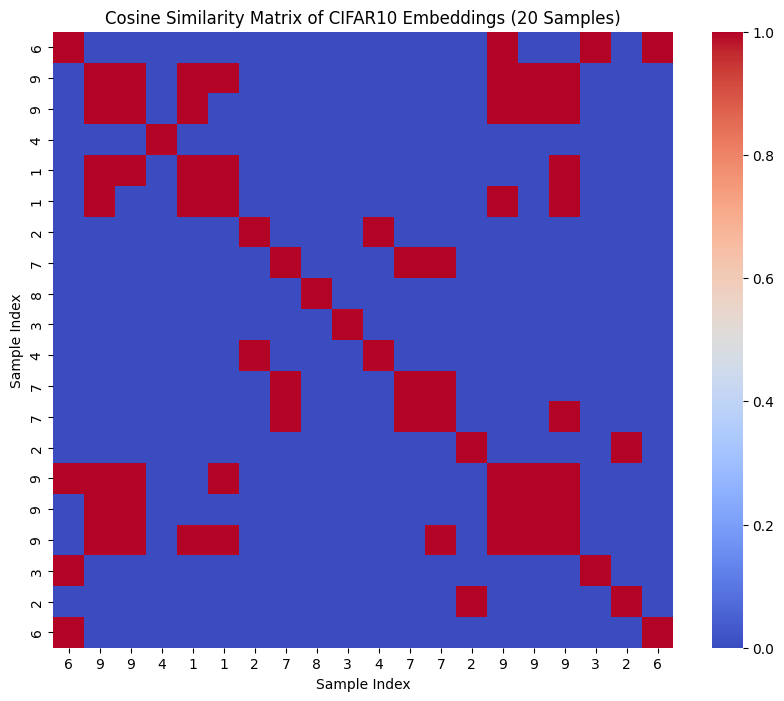

In [5]:

# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix>0.1, annot=False, fmt=".2f", cmap="coolwarm", xticklabels=labels.tolist(), yticklabels=labels.tolist())
plt.title(f"Cosine Similarity Matrix of {dataset_mode} Embeddings (20 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")
plt.show()
